/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

Model Accuracy: 0.928

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       261
           1       1.00      1.00      1.00       117
           2       0.94      0.94      0.94       317
           3       0.92      0.90      0.91       671
           4       0.97      0.96      0.97       408
           5       0.97      0.94      0.96       413
           6       0.85      0.90      0.88       536

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



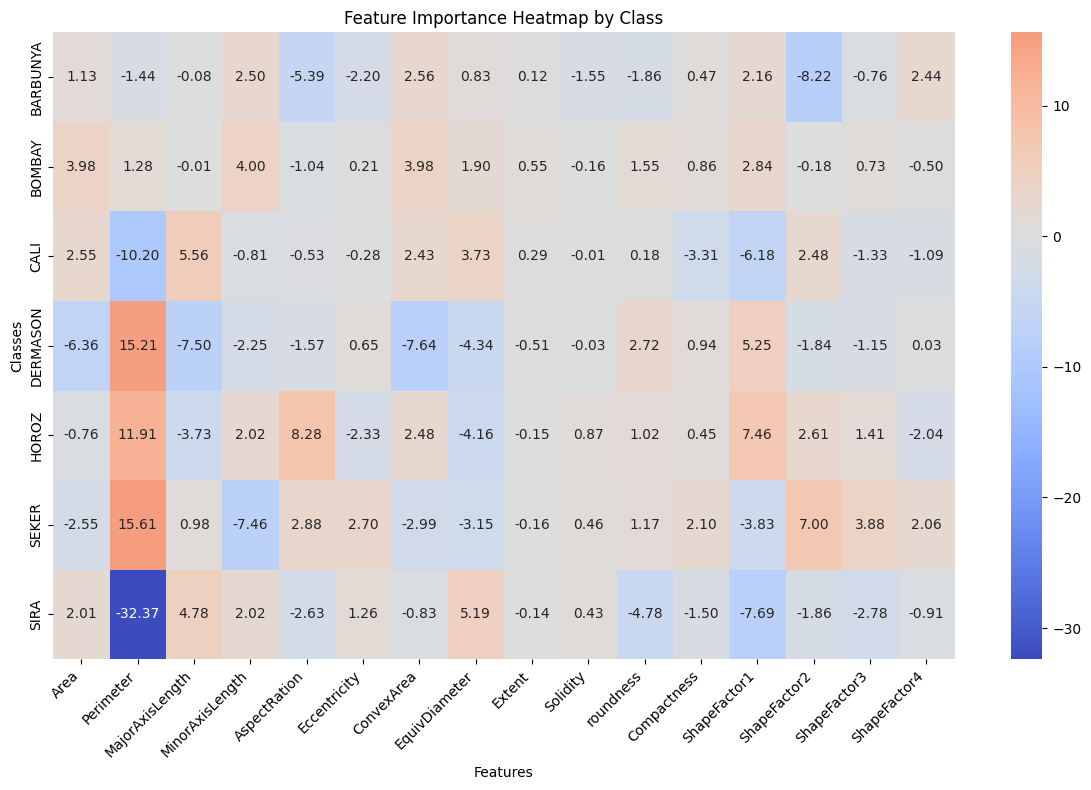

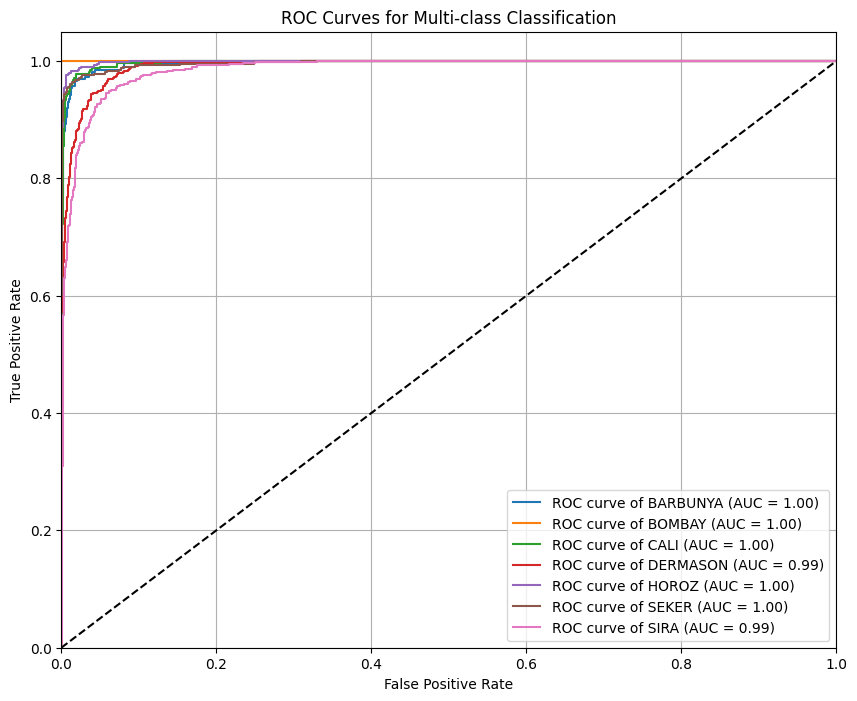

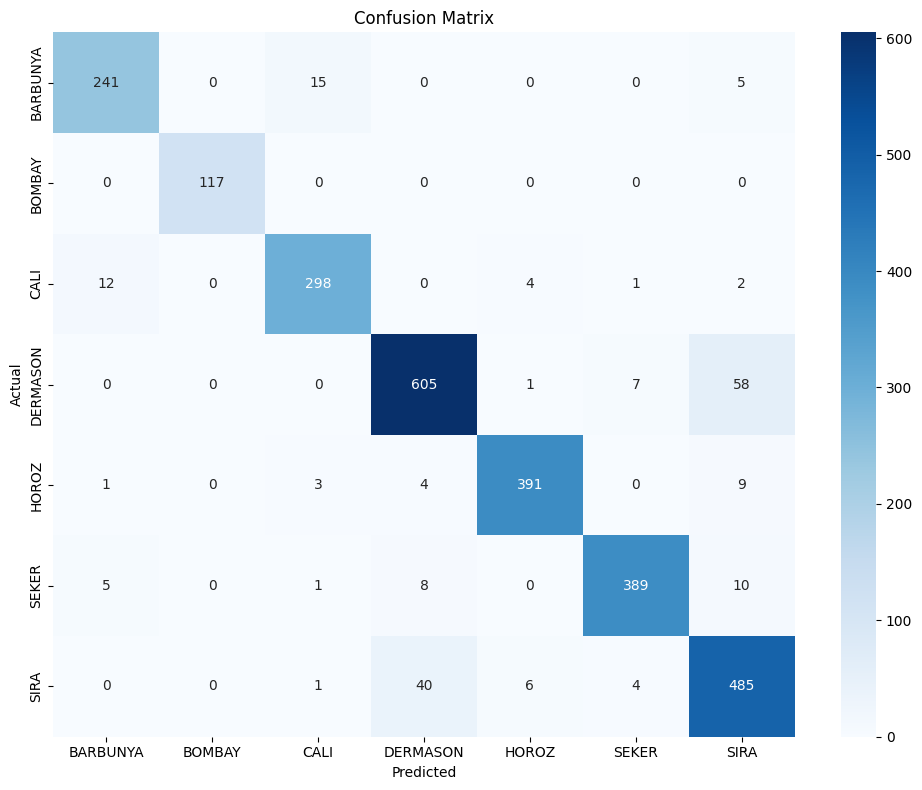

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    # Load the data
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dry_Bean_Dataset.csv')

    # Separate features and target
    X = df.drop('Class', axis=1)
    y = df['Class']

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Encode target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return X_scaled, y_encoded, le.classes_

# 2. Model Training and Evaluation
def train_evaluate_model(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize base model
    # Using 'multinomial' for multi-class classification
    base_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

    # Define hyperparameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'penalty': ['l2']  # Only l2 penalty is supported with multinomial
    }

    # Perform grid search
    grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    return best_model, X_train, X_test, y_train, y_test, y_pred, accuracy, class_report, grid_search.best_params_

# 3. Visualization Functions
def plot_feature_importance(model, feature_names, class_names):
    plt.figure(figsize=(12, 8))

    # Get coefficients for each class
    coef_df = pd.DataFrame(
        model.coef_,
        columns=feature_names,
        index=class_names
    )

    # Plot heatmap of coefficients
    sns.heatmap(coef_df, cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Feature Importance Heatmap by Class')
    plt.xlabel('Features')
    plt.ylabel('Classes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(model, X_test, y_test, class_names):
    # Calculate ROC curve and ROC area for each class
    n_classes = len(class_names)
    y_score = model.predict_proba(X_test)

    plt.figure(figsize=(10, 8))

    # Plot ROC curves for each class
    for i in range(n_classes):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        y_test_binary = (y_test == i).astype(int)
        fpr[i], tpr[i], _ = roc_curve(y_test_binary, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i],
                label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-class Classification')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_test, y_pred, class_names):
    plt.figure(figsize=(10, 8))
    cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    X, y, class_names = load_and_preprocess_data('Dry_Bean_Dataset.csv')

    # Train and evaluate model
    model, X_train, X_test, y_train, y_test, y_pred, accuracy, class_report, best_params = train_evaluate_model(X, y)

    # Print results
    print(f"Best Parameters: {best_params}")
    print(f"\nModel Accuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(class_report)

    # Generate visualizations
    plot_feature_importance(model, X.columns, class_names)
    plot_roc_curves(model, X_test, y_test, class_names)
    plot_confusion_matrix(y_test, y_pred, class_names)